In [27]:
#Model Robustness Comparison Under Distribution Shift

#This experiment compares how different ML models degrade under increasing data drift.

In [29]:
from run_all_models import run_experiment
drift_levels, results = run_experiment()

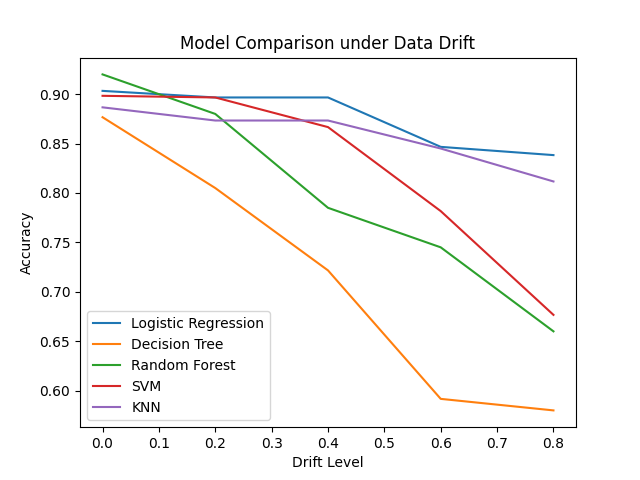

In [30]:
from IPython.display import Image
Image("plots/model_comparison_under_drift.png")

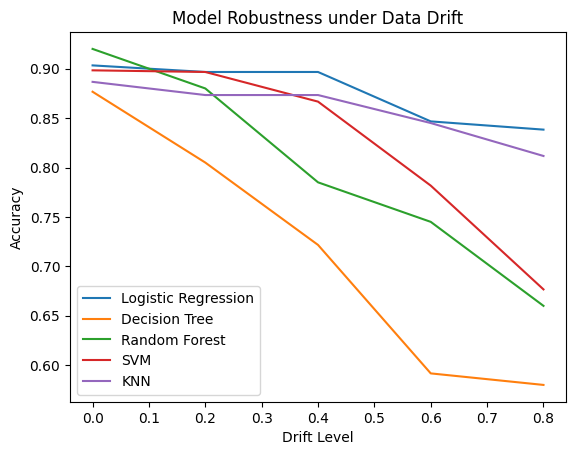

In [31]:
import matplotlib.pyplot as plt

for model_name, acc_list in results.items():
    plt.plot(drift_levels, acc_list, label=model_name)

plt.xlabel("Drift Level")
plt.ylabel("Accuracy")
plt.title("Model Robustness under Data Drift")
plt.legend()
plt.show()

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from drift_simulation import apply_drift

df = pd.read_csv(r"C:\Users\DELL\Downloads\bank-additional-full_encoded.csv")

X = df.drop(['age'], axis=1)  
y = df['age']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values

def compute_drift_score(X_train, X_test):
    from scipy.stats import ks_2samp
    p_values = []
    for i in range(X_train.shape[1]):
        statistic, p_value = ks_2samp(X_train[:, i], X_test[:, i])
        p_values.append(p_value)
    return 1 - np.mean(p_values)

drift_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
drift_scores = []

for drift in drift_levels:
    X_train_drifted, X_test_drifted = apply_drift(X_train, X_test, drift_level=drift)
    score = compute_drift_score(X_train, X_test_drifted)
    drift_scores.append(score)
    print(f"Drift level {drift}: score {score:.4f}")

print("\nDrift levels:", drift_levels)
print("Drift scores:", drift_scores)

Drift level 0.0: score 0.3280
Drift level 0.1: score 1.0000
Drift level 0.2: score 1.0000
Drift level 0.3: score 1.0000
Drift level 0.4: score 1.0000
Drift level 0.5: score 1.0000

Drift levels: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
Drift scores: [0.3279791337073754, 1.0, 1.0, 1.0, 1.0, 1.0]


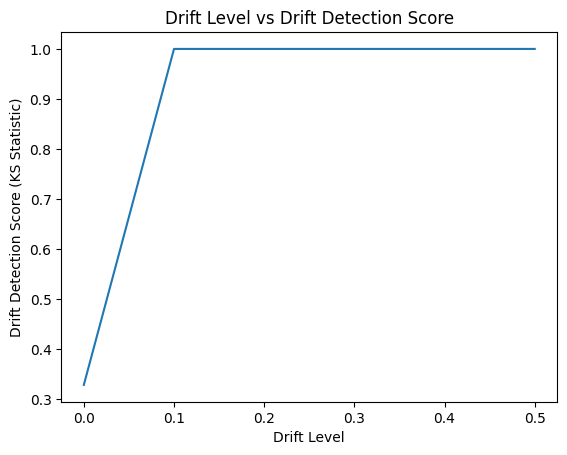

<Figure size 640x480 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt

plt.plot(drift_levels, drift_scores)
plt.xlabel("Drift Level")
plt.ylabel("Drift Detection Score (KS Statistic)")
plt.title("Drift Level vs Drift Detection Score")
plt.show()

plt.savefig("plots/drift_detection_score.png")

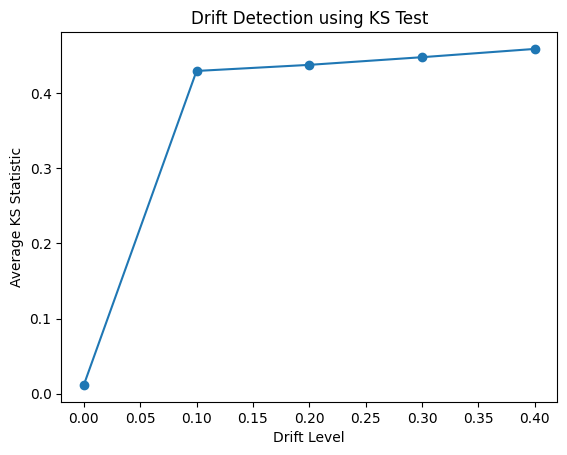

In [72]:
from scipy.stats import ks_2samp
import numpy as np
import matplotlib.pyplot as plt

def compute_ks_drift(X_ref, X_new):
    ks_scores = []

    for i in range(X_ref.shape[1]):  
        stat, _ = ks_2samp(X_ref[:, i], X_new[:, i])
        ks_scores.append(stat)

    return np.mean(ks_scores)  


drift_levels = [0.0, 0.1, 0.2, 0.3, 0.4]
ks_results = []

for drift in drift_levels:
    X_train_drifted, X_test_drifted = apply_drift(X_train, X_test, drift)
    ks_score = compute_ks_drift(X_train, X_test_drifted)
    ks_results.append(ks_score)

plt.plot(drift_levels, ks_results, marker='o')
plt.xlabel("Drift Level")
plt.ylabel("Average KS Statistic")
plt.title("Drift Detection using KS Test")
plt.show()

In [75]:
from scipy.stats import ks_2samp

ks_scores = []

for drift in drift_levels:
    X_train_drifted, X_test_drifted = apply_drift(X_train, X_test, drift_level=drift)
    
    ks = ks_2samp(X_train_drifted[:,0], X_test_drifted[:,0]).statistic
    ks_scores.append(ks)

In [77]:
from drift_monitor import drift_decision

for drift, ks in zip(drift_levels, ks_scores):
    decision = drift_decision(ks)
    print(f"Drift: {drift} | KS: {ks:.3f} | Decision: {decision}")

Drift: 0.0 | KS: 0.012 | Decision: Safe
Drift: 0.1 | KS: 0.180 | Decision: Safe
Drift: 0.2 | KS: 0.203 | Decision: Monitor Closely
Drift: 0.3 | KS: 0.231 | Decision: Monitor Closely
Drift: 0.4 | KS: 0.260 | Decision: Monitor Closely


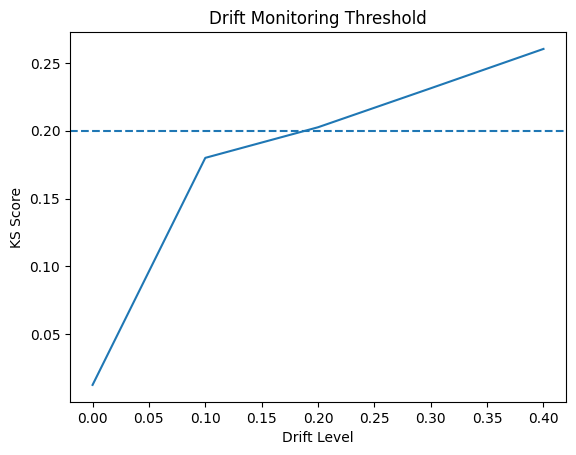

In [81]:
decisions = [drift_decision(ks) for ks in ks_scores]

plt.plot(drift_levels, ks_scores)
plt.axhline(y=0.2, linestyle='--')
plt.title("Drift Monitoring Threshold")
plt.xlabel("Drift Level")
plt.ylabel("KS Score")
plt.show()

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_cm(y_true, y_pred, title, save_path):
    cm = confusion_matrix(y_true, y_pred)

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()

    num_classes = cm.shape[0]
    ticks = np.arange(0, num_classes, max(1, num_classes // 10))
    plt.xticks(ticks)
    plt.yticks(ticks)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_11756\2185845770.py:8: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


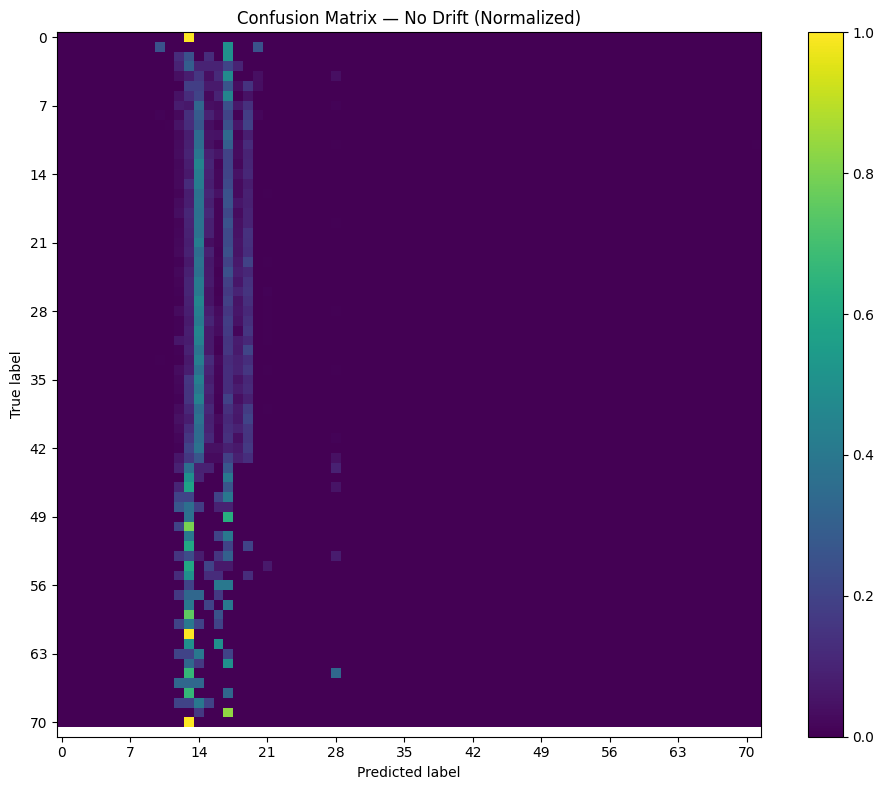

C:\Users\DELL\AppData\Local\Temp\ipykernel_11756\2185845770.py:8: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


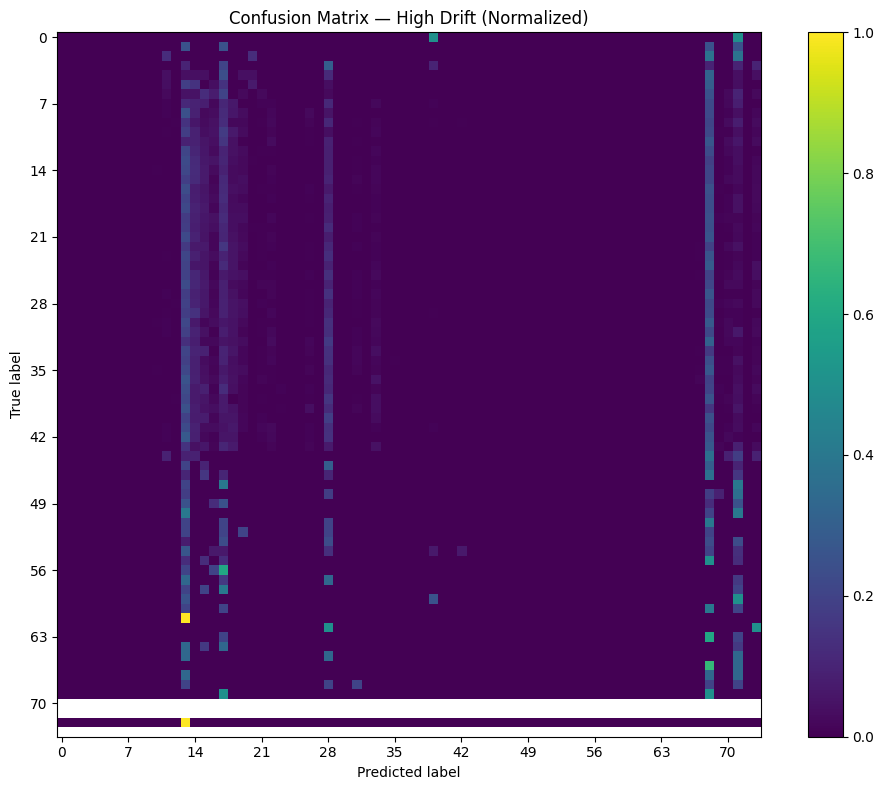

In [35]:
plot_cm(y_test, y_pred_nd,
        "Confusion Matrix — No Drift (Normalized)",
        "plots/confusion_no_drift.png")

plot_cm(y_test, y_pred_hd,
        "Confusion Matrix — High Drift (Normalized)",
        "plots/confusion_high_drift.png")

In [93]:
from scipy.stats import ks_2samp

def detect_drift(original_data, new_data, threshold=0.05):
    """Detects drift using Kolmogorov-Smirnov test"""
    drift_detected = False
    
    for col in range(original_data.shape[1]):
        stat, p_value = ks_2samp(original_data[:, col], new_data[:, col])
        if p_value < threshold:
            drift_detected = True
            break
    
    return drift_detected

In [97]:
drift_detected = detect_drift(X_train, X_train_drifted, threshold=0.05)

from retraining import retrain_and_evaluate

if drift_detected:
    print("Drift detected → Retraining model")

    new_acc = retrain_and_evaluate(model,
                                   X_train_drifted, y_train,
                                   X_test_drifted, y_test)

    print(f"Accuracy after retraining: {new_acc}")